## Noisy Backends
Fake backends allow us to mimmic many of the existing real Quantum systems. But the generic backend allows us to create small and restricted systems and see how those restrictions impact the transpiled code.  

In this case we will be creating a very simple backend from scratch: only H and CX gates. I will be calling this backend Madrid.

In [1]:
from qiskit import QuantumCircuit, transpile
from qiskit.circuit.library import CXGate, HGate, Measure
from qiskit.providers import BackendV2, Options
from qiskit.transpiler import Target, InstructionProperties
from qiskit.visualization import plot_gate_map, plot_error_map

In [2]:
class MadridBackend(BackendV2):
    def __init__(self, qbits = 5, coupling = None, noisy = True, name="noisy_backend"):
        super().__init__(name=name)

        # Target with qbits
        self._target = Target(num_qubits=qbits)

        # Add H (only one qbit pair is not noisy if noise has been activated)
        self._target.add_instruction(
            HGate(),
            {(i,): InstructionProperties(
                error=0.001 if (i==qbits-1 or not noisy) else 0.2
            ) for i in range(qbits)}
        )

        # Add CX (only one qbit pair is not noisy if noise has been activated)
        self._target.add_instruction(
            CXGate(),
            {
                (i,(i+1) % qbits): InstructionProperties(
                    error=0.001 if (not noisy or i==qbits-1) else 0.2
                ) for i in range(qbits)
            } | {
                ((i+1) % qbits,i): InstructionProperties(
                    error=0.001 if (not noisy or i==qbits-1) else 0.2
                ) for i in range(qbits) 
            }            
        )
        
        # Add Measurements
        self._target.add_instruction(
            Measure(),
            {(i,): InstructionProperties(error=0.001) for i in range(qbits)}
        )

    # Methods requiring implementation
    @classmethod
    def _default_options(cls):
        return Options()

    @property
    def max_circuits(self):
        return None   

    def run(self, run_input, **options):
        raise NotImplementedError("Transpilation-only backend.")

    @property
    def target(self):
        return self._target
        

We will be defining a very simple circuit.

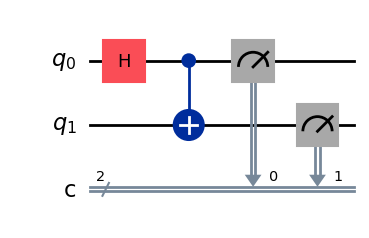

In [3]:
qc = QuantumCircuit(2,2)
qc.h(0)
qc.cx(0,1)
qc.measure([0,1],[0,1])
qc.draw('mpl')

Now we define a 5 qbit backend with small levels of noise in all gates.

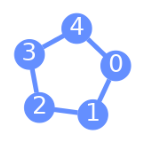

In [4]:
backend = MadridBackend(noisy=False,name = 'low error')
plot_gate_map(backend)

We can see that the error levels are small both in H and CX for all qbits.

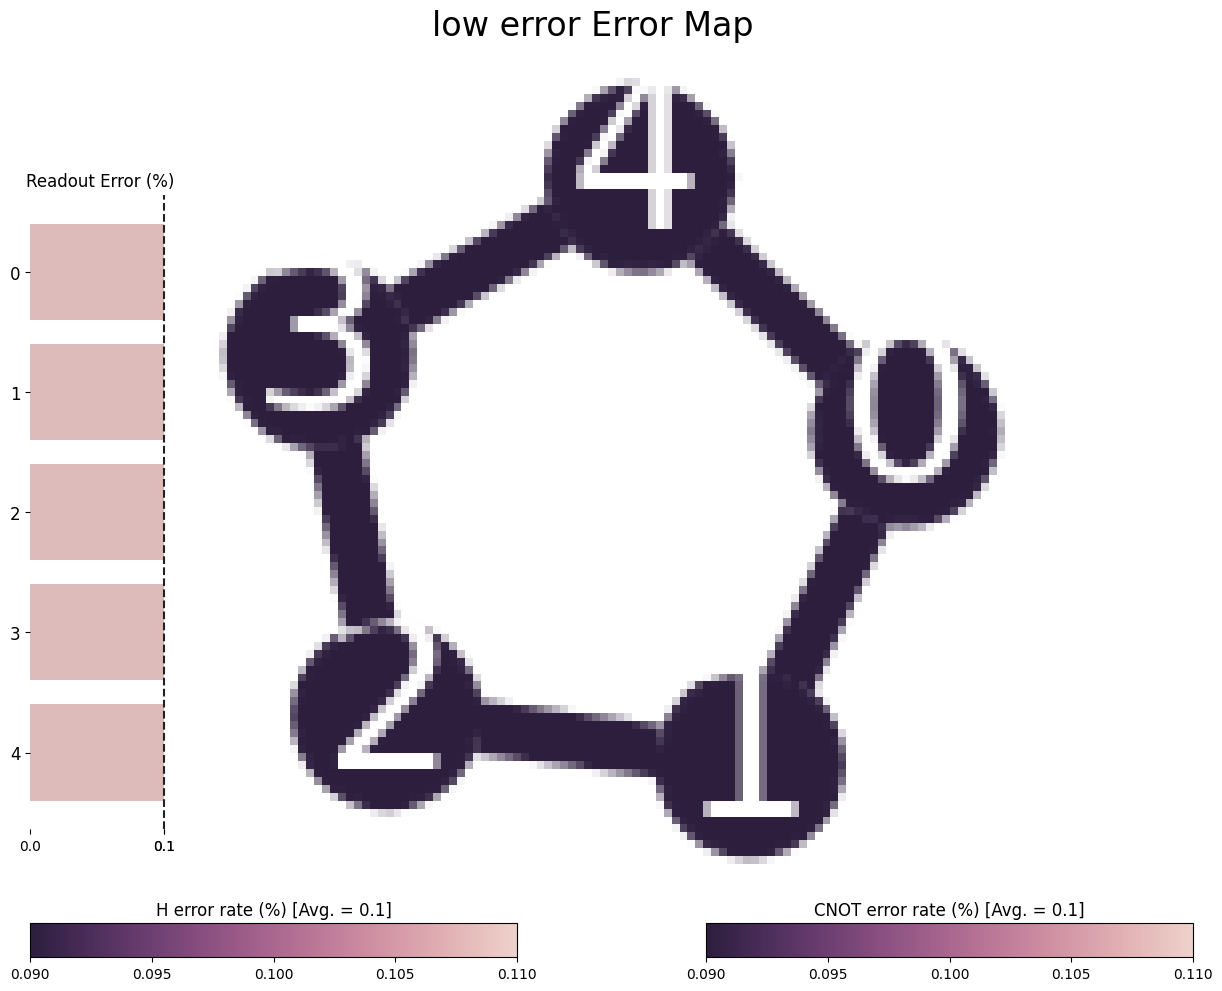

In [5]:
plot_error_map(backend)

Targeting this low-error backend we are going to transpile our circuit.

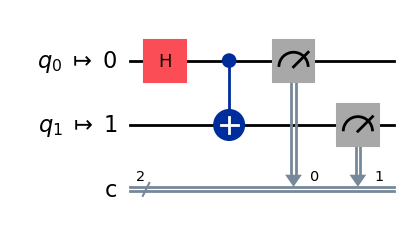

In [6]:
qct = transpile(qc,backend,seed_transpiler=42)
qct.draw('mpl')

Now we will set a higher error rate for all gates except for one.

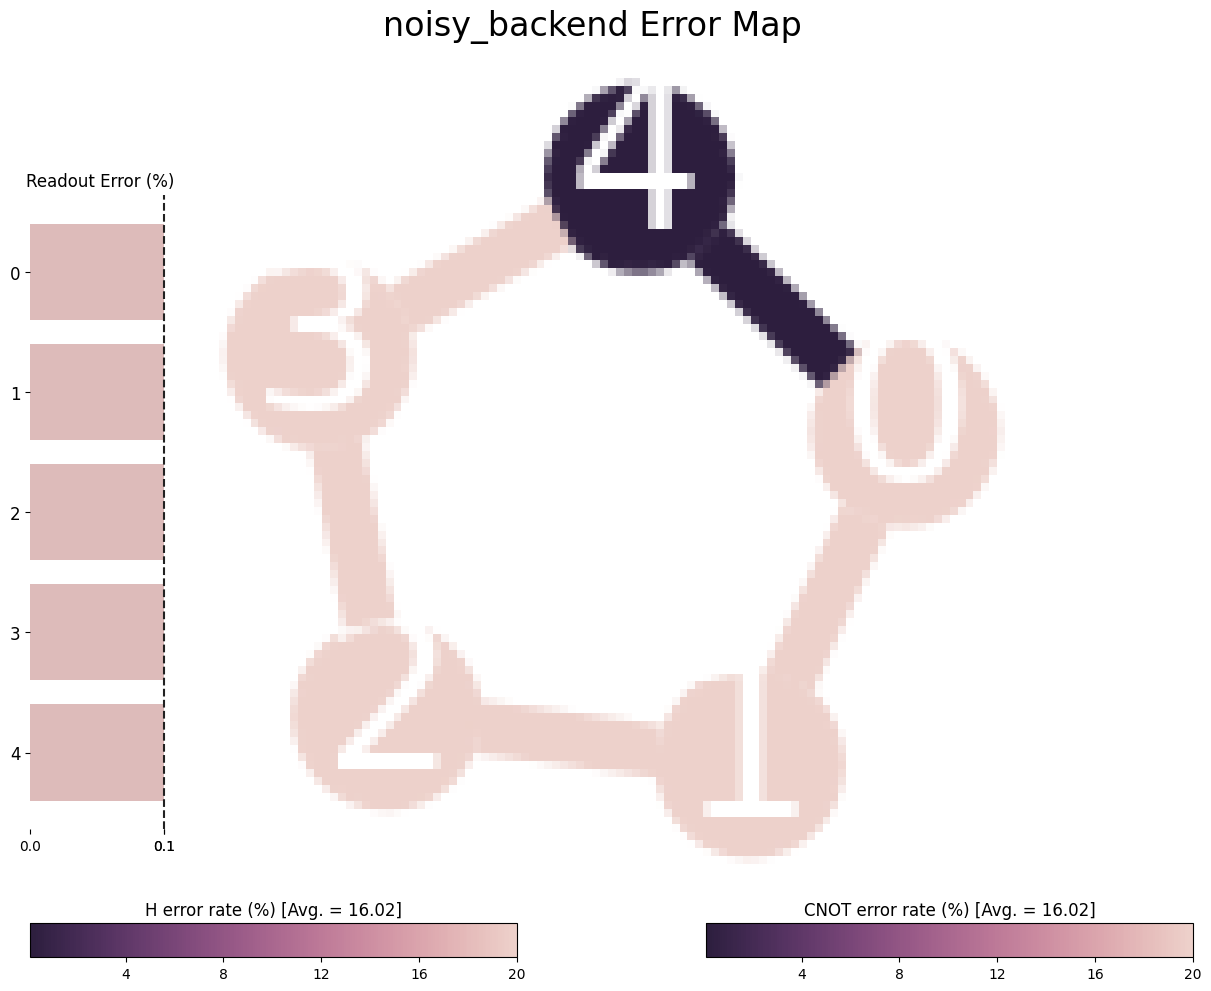

In [7]:
backend = MadridBackend(noisy=True)
plot_error_map(backend)

We will transpile again targeting this noisy backend and check if the transpiled code is different.

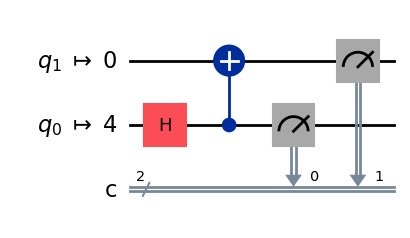

In [8]:
qct = transpile(qc,backend,seed_transpiler=42)
qct.draw('mpl')

The transpiler has moved both the H and CX gates to the pair of qbits reporting the lowest error.